# Logistic Regression

What is Logistic Regression?

Technically a regression algorithm (goal is to find the values for the coefficients that weight each input variable)

Used for predicting discrete outcomes (binomial and multinomial)

Because the prediction for the output is transformed using the logistic function, a non-linear function, it is a classification algorithm.

The output is a value between 0 and 1 that represents the probability of one class over the other.

Like linear regression, logistic regression works better when you remove attributes that are either unrelated to the output variable or correlated to other attributes.

- Pros

    High interpretabability. It's explainable to others, i.e. it's useful for understanding the influence of several independent variables on a single outcome variable.
    
    We can choose to ‘snap’ predictions to 0 and 1 via a rule (such as if < .5, 0 else 1) OR we can choose to use the output as is, which is a probability of being class 1.
    
    It’s a fast model and is a good place to start with a benchmark for comparing with other classification algorithms.
    
    Very efficient and does not require many computational resources. Runs fast.
    
    Outputs clear predicted probabilities.
<br>
<br>
<br>
- Cons

    Assumes all predictors are independent of each other.
    
    Missing values must be dealt with prior to fitting the model.
    
    We can’t solve non-linear problems with logistic regression since it’s decision surface is linear.
    
    Not always as accurate as other classification algorithms.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pydataset import data

# read Iris data from pydatset
df = data('iris')

# convert column names to lowercase, replace '.' in column names with '_'
df.columns = [col.lower().replace('.', '_') for col in df]

# we will have 2 different target variables 
dummies = pd.get_dummies(df['species'], drop_first=True)

df = pd.concat([df, dummies], axis=1).drop(columns=['species'])
df.head()

,sepal_length,sepal_width,petal_length,petal_width,versicolor,virginica
1,5.1,3.5,1.4,0.2,0,0
2,4.9,3.0,1.4,0.2,0,0
3,4.7,3.2,1.3,0.2,0,0
4,4.6,3.1,1.5,0.2,0,0
5,5.0,3.6,1.4,0.2,0,0


## Train Validate Test

**Now we'll do our train/validate/test split:**

We will walk through the lesson aiming to predict versicolor.
    
We'll do exploration and train our model on the train data
    
We tune our model on validate, since it will be out-of-sample until we use it.
    
And keep the test nice and safe and separate, for our final out-of-sample dataset, to see how well our tuned model performs on new data.

In [2]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


In [3]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='versicolor', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['versicolor','virginica'])
y_train = train.versicolor

X_validate = validate.drop(columns=['versicolor','virginica'])
y_validate = validate.versicolor

X_test = test.drop(columns=['versicolor','virginica'])
y_test = test.versicolor

## Documentation:

**Arguments**

- penalty: str, 'l1' or 'l2', default: 'l2', Used to specify the norm used in the penalization. The 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. We will discuss l1 & l2 penalties & regularization

- C: float, default: 1.0, Inverse of regularization strength; must be a positive float.

- class_weight: dict or 'balanced', default: None, Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

- random_state: set the seed for reproducibility.

- intercept_scaling: float, default 1. Useful only when the solver 'liblinear' is used and self.fit_intercept is set to True and you have not already scaled your data.

- solver: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default: 'liblinear', but will change to 'lbfgs' in v 0.22. The solver is the algorithm to use in the optimization problem. For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones. For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss; 'liblinear' is limited to one-versus-rest schemes. 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas 'liblinear' and 'saga' handle L1 penalty. If using sag and saga solvers, make sure the features are on a similar scale.

- max_iter: int, default: 100, Useful only for the newton-cg, sag and lbfgs solvers, Maximum number of iterations taken for the solvers to converge.

- multi_class: I recommend using other algorithms for multiclass or one-vs-rest if you want to use logistic regression. options: {'ovr', 'multinomial', 'auto'}, default: 'ovr' (one-versus-rest). If the option chosen is 'ovr', then a binary problem is fit for each label. For 'multinomial' the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. 'multinomial' is unavailable when solver='liblinear'. 'auto' selects 'ovr' if the data is binary, or if solver='liblinear', and otherwise selects 'multinomial'.



## Model 1

**For the first model, we will set the solver to be lbfgs.**

### Make the Model

Create the object

In [4]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [5]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

## Fit the model

Fit the logistic regression algorithm to the training data.

In [6]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

## Feature Importance

Evaluate importance, or weight, of each feature, using the coefficients.

Evaluate the intercept of the model.

In [7]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.45745489 -4.33000304  2.00440881 -2.79033335]]
Intercept: 
 [14.54733857]


## Make Predictions

Estimate whether or not the species is versicolor for each observation, using the training data.

In [8]:
y_pred = logit.predict(X_train)

## Estimate Probability

Estimate the probability of species being versicolor for each observation, using the training data.

In [9]:
y_pred_proba = logit.predict_proba(X_train)

## Evaluate Model

Compute the Accuracy

In [10]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.55


Create a confusion matrix

In [11]:
print(confusion_matrix(y_train, y_pred))

[[18 38]
 [ 0 28]]


Create a classificaiton report

In [12]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.32      0.49        56
           1       0.42      1.00      0.60        28

    accuracy                           0.55        84
   macro avg       0.71      0.66      0.54        84
weighted avg       0.81      0.55      0.52        84



## Model 2
We can create new models by changing features we feed the algorithm, hyperparameters, and/or the alogrithm itself. For this second model, we will adjust our hyperparameter, C.

### Make the Model

create the object

In [14]:
logit2 = LogisticRegression(C=.1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

## Fit the model

Fit the logistic regression algorithm to the training data.

In [15]:
logit2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 99}, random_state=123)

## Feature Importance

Evaluate importance, or weight, of each feature, using the coefficients.

Evaluate the intercept of the model.

In [17]:
print('Coefficient: \n', logit2.coef_)
print('Intercept: \n', logit2.intercept_)

Coefficient: 
 [[-0.20880009 -1.67727952  1.00954681 -0.25663236]]
Intercept: 
 [6.02992374]


## Make Predictions

Estimate whether or not the species is versicolor for each observation, using the training data.

In [18]:
y_pred = logit2.predict(X_train)

## Estimate Probability

Estimate the probability of species being versicolor for each observation, using the training data.

In [19]:
y_pred_proba = logit2.predict_proba(X_train)

## Evaluate Model

Compute the Accuracy

In [20]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.40


Create a confusion matrix

In [21]:
print(confusion_matrix(y_train, y_pred))

[[ 6 50]
 [ 0 28]]


Create a classificaiton report

In [22]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        56
           1       0.36      1.00      0.53        28

    accuracy                           0.40        84
   macro avg       0.68      0.55      0.36        84
weighted avg       0.79      0.40      0.31        84



Precision: 
T
P
(
T
P
+
F
P
)

Recall: 
T
P
(
T
P
+
F
N
)

F1-Score: A measure of accuracy. The harmonic mean of precision & recall. The harmonic mean is the reciprocal of the arithmetic mean of the reciprocals.

F1 
∈
[
0
,
1
]

F1-score = harmonic mean = 
2
1
p
r
e
c
i
s
i
o
n
+
1
r
e
c
a
l
l

Support: number of occurrences of each class.



## Validate Models
Evaluate on Out-of-Sample data

Are either overfitting? Let's validate on unseen data, X_validate. This means we use logit & logit2 to predict on X_validate.

In [23]:
# make predictions

y_pred1 = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate)


print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))

print("Model 2: solver = lbfgs, c = .1")

# accuracy of model 2
print('Accuracy: {:.2f}'.format(logit2.score(X_validate, y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred2))

# classification report of model 2
print(classification_report(y_validate, y_pred2))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.53
[[ 7 17]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.29      0.45        24
           1       0.41      1.00      0.59        12

    accuracy                           0.53        36
   macro avg       0.71      0.65      0.52        36
weighted avg       0.80      0.53      0.50        36

Model 2: solver = lbfgs, c = .1
Accuracy: 0.33
[[ 0 24]
 [ 0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.33      1.00      0.50        12

    accuracy                           0.33        36
   macro avg       0.17      0.50      0.25        36
weighted avg       0.11      0.33      0.17        36



## Test Model

Using the best model, compute the accuracy of the model when run on the test data.

In [24]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.47
[[ 4 16]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        20
           1       0.38      1.00      0.56        10

    accuracy                           0.47        30
   macro avg       0.69      0.60      0.44        30
weighted avg       0.79      0.47      0.41        30



## Visualize Model

In [25]:
# create array of probabilities of being versicolor (versicolor == 1)

y_pred_proba = np.array([i[1] for i in y_pred_proba])


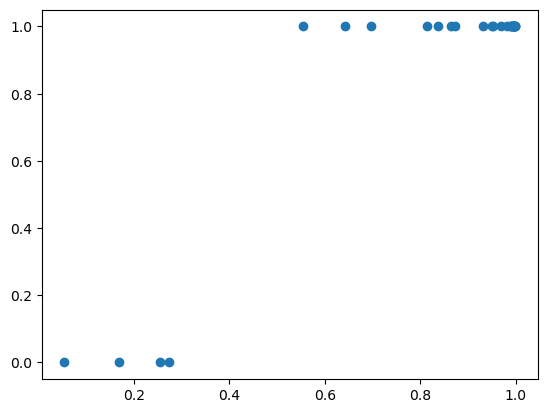

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

# scatter plot where x is the probabilities and y is the class (0, 1)
ax.scatter(y_pred_proba, y_pred)